In [1]:
import os
import math
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import pickle as pkl
import matplotlib.pyplot as plt

%matplotlib inline

/home/veronica1428/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
test_csv_path = os.getcwd() + os.sep + "datasets" + os.sep + "csv" + os.sep + "test.csv"
train_csv_path = os.getcwd() + os.sep + "datasets"+ os.sep + "csv" + os.sep + "train.csv"

In [3]:
#get the csv data
test_csv = pd.read_csv(test_csv_path)
train_csv = pd.read_csv(train_csv_path)

In [4]:
train_csv.head()

,row_id,age,gender,view_position,image_name,detected
0,id_0,45,M,0,scan_0000.png,class_3
1,id_1,57,F,0,scan_0001.png,class_3
2,id_10,58,M,0,scan_00010.png,class_3
3,id_1000,64,M,0,scan_0001000.png,class_6
4,id_10000,33,M,1,scan_00010000.png,class_3


In [5]:
train_csv = train_csv[train_csv.age <= 100]
test_csv = test_csv[test_csv.age <= 100]

Text(0,0.5,'Counts')

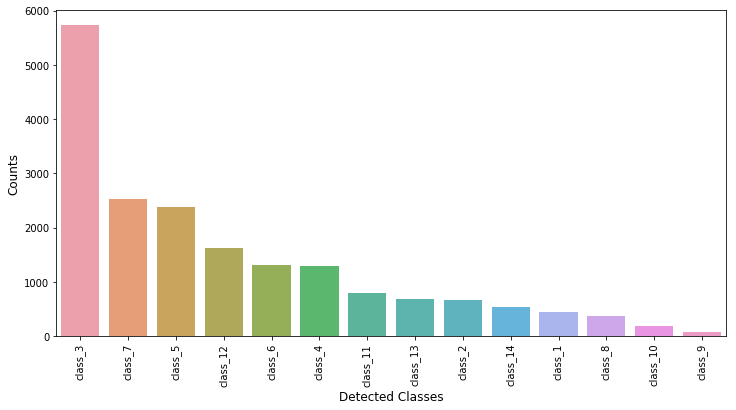

In [6]:
detected_train_counts = train_csv.detected.value_counts()
detected_train_freq = detected_train_counts/detected_train_counts.sum() * 100
# print(detected_train_counts)
# print(detected_train_freq)
plt.figure(figsize = (12,6))
sns.barplot(detected_train_counts.index, detected_train_counts.values, alpha=0.9)
plt.xticks(rotation='vertical')
plt.xlabel('Detected Classes', fontsize=12)
plt.ylabel('Counts', fontsize=12)

Text(0,0.5,'Counts')

/home/veronica1428/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


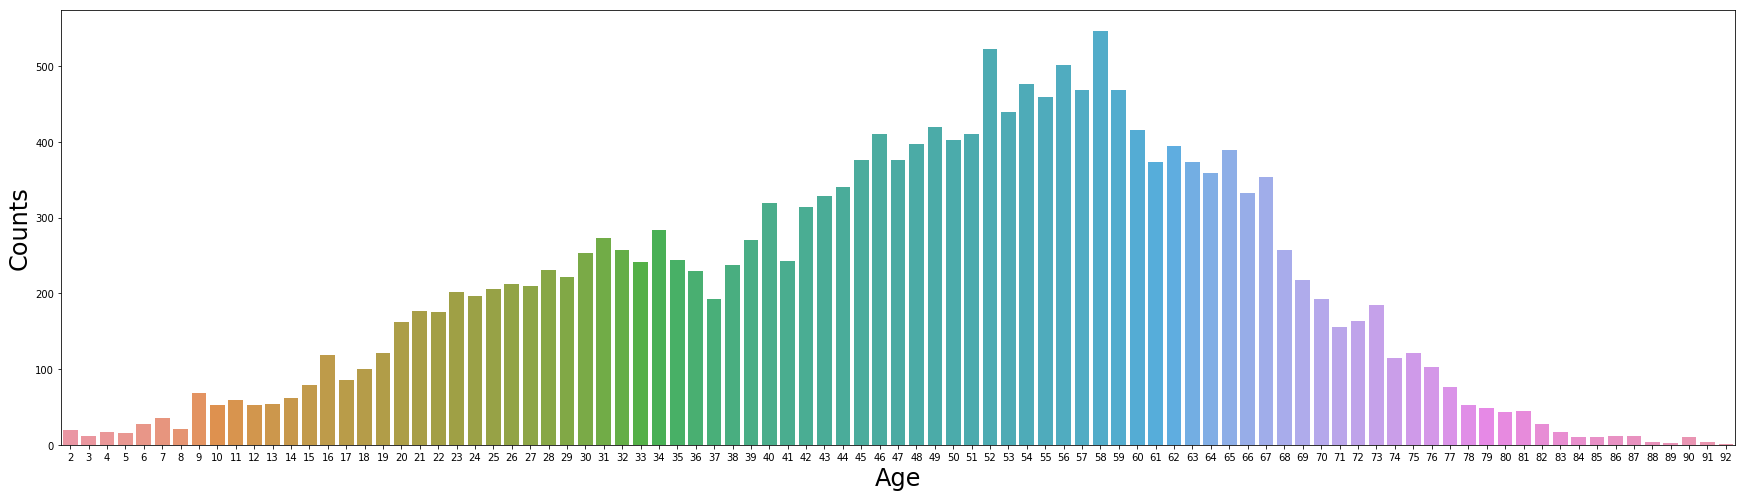

In [7]:
plt.figure(figsize=(30,8))
sns.countplot(train_csv.age)
axis_font = {'fontname':'Arial', 'size':'24'}
plt.xlabel('Age', **axis_font)
plt.ylabel('Counts', **axis_font)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

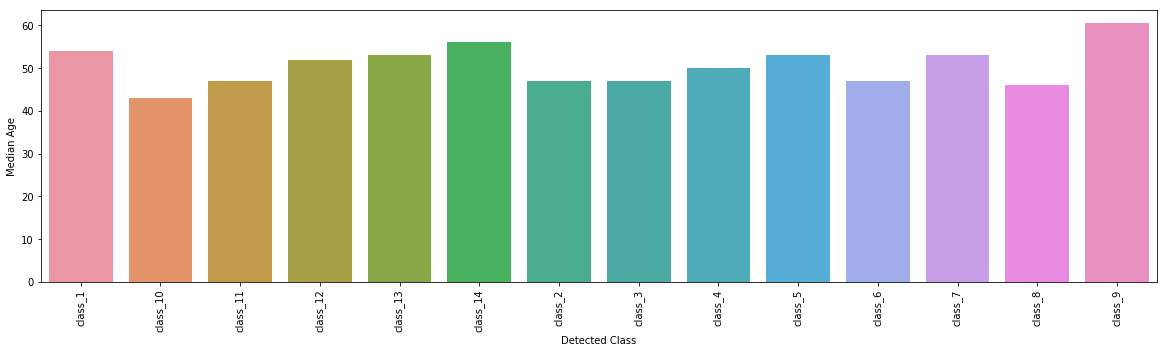

In [8]:
#by median age
temp = train_csv.groupby(['detected']).median()
plt.figure(figsize=(20,5))
sns.barplot(temp.index, temp.age)
plt.xlabel('Detected Class')
plt.ylabel('Median Age')
plt.xticks(rotation='vertical')

(1024, 1024, 3)


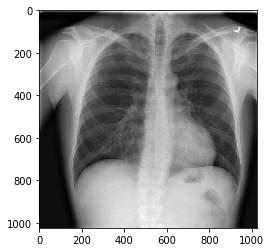

In [9]:
#read the image files
TRAIN_PATH = os.getcwd() + os.sep + 'datasets' + os.sep + 'train_/'
TEST_PATH = os.getcwd() + os.sep + 'datasets' + os.sep + 'test_/'

import cv2
from glob2 import glob

index = 20
img = cv2.imread(TRAIN_PATH+train_csv.image_name.values[index])
print(img.shape)
plt.imshow(img)

In [10]:
from tqdm import tqdm
def read_img(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (128, 128))
    return img

In [11]:
train_img_list = []
for file in tqdm(train_csv.image_name.values):
    fpath = os.path.join(TRAIN_PATH, file)
    img = read_img(fpath)
    #img  = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    train_img_list.append(img)  

100%|██████████| 18574/18574 [05:25<00:00, 57.14it/s]


In [12]:
#print(np.dtype(np.float16).itemsize)
#del train_img_array

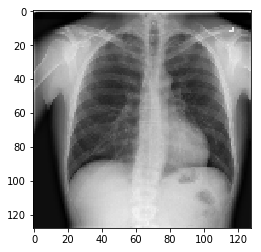

In [13]:
#check same image with smaller dimensions
plt.imshow(train_img_list[index])

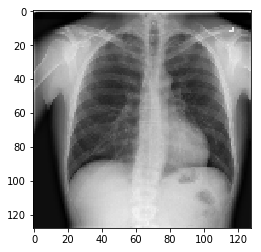

In [14]:
#rescale the images
train_img_array = np.array(train_img_list, np.float32) / 255.
train_img_array.shape
del train_img_list
plt.imshow(train_img_array[index])

In [15]:
print(train_img_array.shape)
print(sys.getsizeof(train_img_array))

(18574, 128, 128, 3)
3651797136


In [18]:
with open('resized_train_file.pkl', 'wb') as f:
    pkl.dump(train_img_array, f, protocol=4)

In [11]:
#restore the train_img array from using pickle
file = open('resized_train_file.pkl', 'rb')
train_load = pkl.load(file)
file.close()

In [12]:
print(train_load.shape)

(18574, 128, 128, 3)


(128, 128, 3)


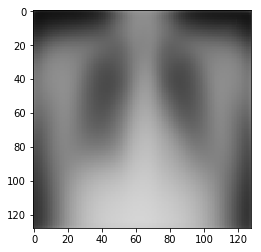

In [13]:
#take mean of the images
mean_train_img = np.mean(train_load, axis=0)
print(mean_train_img.shape)
plt.imshow(mean_train_img)

(128, 128, 3)


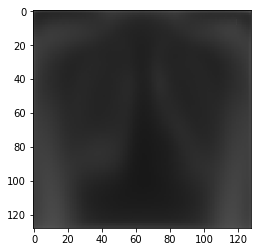

In [14]:
#calculate the standard deviation of the images
std_train_img = np.std(train_load, axis=0)
print(std_train_img.shape)
plt.imshow(std_train_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(18574, 128, 128, 3)


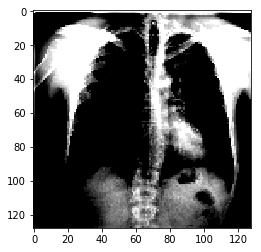

In [15]:
#Normalize the images
norm_train_img = (train_load - mean_train_img) / (std_train_img)
print(norm_train_img.shape)
plt.imshow(norm_train_img[index])

In [16]:
train_label_list = train_csv.detected.tolist()

label_dict = {k: v+1 for v,k in enumerate(set(train_label_list)) }
y_train = [label_dict[k] for k in train_label_list]    

In [17]:
#convert train labels to one-hot representation
from keras.utils import to_categorical

y_train = to_categorical(y_train)

Using TensorFlow backend.


In [18]:
#use keras to build model of your own
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import VGG16, ResNet50
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam
from IPython.display import display
from PIL import Image

In [19]:
#datagen = ImageDataGenerator(rotation_range=0.1, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# datagen = ImageDataGenerator(horizontal_flip=True)

# if not os.path.exists('augmented_img'):
#     os.makedirs('augmented_img')
# else:
#     for f in glob(os.path.join(TRAIN_PATH, 'augmented_img/*')):
#         os.remove(f)  

# THRESHOLD = 1500

# for key in detected_train_counts.index.values:
    
#     i=0
#     df = train_csv.loc[train_csv.detected.values == key]
#     print(key)
#     length = len(df)
#     #print(length)
#     value_add = THRESHOLD  - length if (length < THRESHOLD) else 0
#     num_images = math.ceil(value_add / length) if value_add != 0 else 0

#     x = [train_load[val, :, :, :] for val in df.index.values[:len(df)]]
    
#     for batch_x, batch_y in datagen.flow(np.asarray(x), batch_size=1, save_to_dir='augmented_img', save_prefix='xray' + key, save_format='png'):
#         i += 1
#         if i > 1:
#             print(num_images)
#             break
    

In [20]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(128,128,3))
for layer in base_model.layers[1:]:
    layer.trainable = False
    
model = Sequential([
                    base_model, 
                    Flatten(), 
                    Dense(512, activation='relu'),
                    Dropout(0.25),
                    Dense(15, activation='softmax')])

for layer in model.layers[0].layers[-60:]:
    layer.trainable = True
    
optimizer = Adam(0.0001, decay=0.00000001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                7695      
Total params: 18,917,199
Trainable params: 18,917,199
Non-trainable params: 0
_________________________________________________________________


In [48]:
#model.load_weights('weights' + os.sep + 'resnet50.hdf5')

In [49]:
#freeze layers which do not need to be trained
# for layer in model.layers[:5]:
#     layer.trainable = False
    
# final_model = model.output
# final_model = Flatten()(final_model)
# final_model = Dense(512, activation='relu')(final_model)
# predictions = Dense(15, activation='softmax')(final_model)

# mod = Model(inputs=model.inputs, outputs=predictions)
# mod.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [50]:
# datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# mod.fit_generator(datagen.flow(train_load, y_train, batch_size=32, save_to_dir='augmented_img', 
#                                 save_prefix='xray', save_format='png'), epochs=1)

In [51]:
# model = Sequential()
# model.add(Convolution2D(32, (3,3), padding='same', activation='relu', input_shape=(128,128,3)))
# model.add(Convolution2D(32, (3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Convolution2D(64, (3,3), padding='same', activation='relu'))
# model.add(Convolution2D(64, (3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Convolution2D(128, (3,3), padding='same', activation='relu'))
# model.add(Convolution2D(128, (3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(y_train.shape[1], activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()

In [52]:
#early_stops = EarlyStopping(patience=3, monitor='val_acc')

In [53]:
# train_load = np.expand_dims(train_load, axis=0)
# train_load = np.rollaxis(train_load, 0, 4)

In [57]:
#checkpoint
#filepath = "weights_improvement_{epoch:02d}_{val_acc:0.2f}.hdf5"
filepath = 'weights_best.hdf5'
model_check_point = ModelCheckpoint(filepath, save_best_only=True)
model.fit(train_load[1:2000], y_train[1:2000], batch_size=64, epochs=1, validation_split=0.3, callbacks=[model_check_point])

Train on 3499 samples, validate on 1500 samples
Epoch 1/1
3499/3499 [==============================] - 1033s 295ms/step - loss: 2.2802 - acc: 0.2901 - val_loss: 2.2442 - val_acc: 0.3007


In [21]:
model.load_weights('weights_best.hdf5')

In [22]:
test_img = []
for file in tqdm(test_csv[:500].image_name.values):
    fpath = os.path.join(TEST_PATH, file)
    test_img.append(read_img(fpath))

100%|██████████| 500/500 [00:06<00:00, 72.72it/s]


In [23]:
test_array = np.array(test_img, np.float32) / 255.
test_array = (test_array - np.mean(test_array, axis=0)) / np.std(test_array, axis=0)

In [24]:
pred = model.predict(test_array)
pred = np.argmax(pred, axis=1)

In [25]:
y_dict = dict()
y_dict = {v:k for k,v in label_dict.items()}
pred_labels = [y_dict[k] for k in pred]

In [26]:
sub_df = pd.DataFrame({'row_id':test_csv[:500].row_id, 'detected':pred_labels})
sub_df.to_csv('submission.csv', index=False)